# Cardiovascular Risk Prediction
## Phase 1: Data Preprocessing & Exploratory Data Analysis

**Dataset:** cardio_base.csv  
**Goal:** Clean data, engineer features, and prepare for ML model training

In [43]:
import os
import random
import numpy as np
import tensorflow as tf
import torch

# =============================================================================
# CELL: Configuration and Reproducibility Setup
# =============================================================================

# Set seed for reproducibility
seed_value = 42

# 1. Set `PYTHONHASHSEED` environment variable
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator
tf.random.set_seed(seed_value)

# 5. Set `torch` pseudo-random generator
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)  # if you are using GPU

# =============================================================================
# CELL: Path Configuration
# =============================================================================

# Define base paths - make them configurable
import os
from pathlib import Path

# Get the current notebook directory
notebook_dir = Path.cwd()

# Define data path - can be overridden by environment variable
DATA_PATH = os.environ.get('CARDIO_DATA_PATH', str(notebook_dir / 'data'))
# Define output path - can be overridden by environment variable
OUTPUT_PATH = os.environ.get('CARDIO_OUTPUT_PATH', str(notebook_dir / 'output'))

# Create directories if they don't exist
os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(OUTPUT_PATH, exist_ok=True)

print(f"Data path: {DATA_PATH}")
print(f"Output path: {OUTPUT_PATH}")
print(f"Random seed: {seed_value}")

Data path: /content/data
Output path: /content/output
Random seed: 42


In [44]:
from google.colab import drive
import os

# Only mount drive if we're in Colab and need to access files there
if 'COLAB_GPU' in os.environ:
    drive.mount('/content/drive')
    # If you need to access files from Drive, you can still do it
    # but make it configurable
    if os.environ.get('USE_DRIVE_DATA', 'false').lower() == 'true':
        base_path = "/content/drive/MyDrive/Cardiac Failure/"
        os.chdir(base_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# base_path = "/content/drive/MyDrive/Cardiac Failure/"
# os.chdir(base_path)

In [46]:
# =============================================================================
# CELL: All Imports (Consolidated)
# =============================================================================

import os
import json
import joblib
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc, classification_report,
    confusion_matrix, precision_recall_curve, average_precision_score,
    recall_score, precision_score, f1_score
)

warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("BYTE2BEAT: CARDIOVASCULAR RISK PREDICTION - DATA PREPROCESSING")
print("-" * 85)
print("Importing libraries...")

BYTE2BEAT: CARDIOVASCULAR RISK PREDICTION - DATA PREPROCESSING
-------------------------------------------------------------------------------------
Importing libraries...


In [47]:
# =============================================================================
# CELL: Define Feature Interpretations (Single Source of Truth)
# =============================================================================

feature_interpretations = {
    'ap_hi': {
        'name': 'Systolic Blood Pressure',
        'unit': 'mmHg',
        'ranges': [
            {'max': 120, 'interpretation': 'Normal blood pressure'},
            {'max': 130, 'interpretation': 'Elevated blood pressure'},
            {'max': 140, 'interpretation': 'Stage 1 hypertension'},
            {'max': 180, 'interpretation': 'Stage 2 hypertension'},
            {'max': float('inf'), 'interpretation': 'Hypertensive crisis'}
        ]
    },
    'ap_lo': {
        'name': 'Diastolic Blood Pressure',
        'unit': 'mmHg',
        'ranges': [
            {'max': 80, 'interpretation': 'Normal blood pressure'},
            {'max': 90, 'interpretation': 'Stage 1 hypertension'},
            {'max': 120, 'interpretation': 'Stage 2 hypertension'},
            {'max': float('inf'), 'interpretation': 'Hypertensive crisis'}
        ]
    },
    'cholesterol': {
        'name': 'Cholesterol',
        'unit': 'category',
        'value_map': {
            1: 'Normal cholesterol',
            2: 'Above normal cholesterol',
            3: 'Well above normal cholesterol'
        }
    },
    'gluc': {
        'name': 'Glucose',
        'unit': 'category',
        'value_map': {
            1: 'Normal glucose',
            2: 'Above normal glucose',
            3: 'Well above normal glucose'
        }
    },
    'smoke': {
        'name': 'Smoking Status',
        'unit': 'binary',
        'value_map': {
            0: 'Non-smoker',
            1: 'Active smoker'
        }
    },
    'alco': {
        'name': 'Alcohol Consumption',
        'unit': 'binary',
        'value_map': {
            0: 'Does not consume alcohol',
            1: 'Consumes alcohol'
        }
    },
    'active': {
        'name': 'Physical Activity',
        'unit': 'binary',
        'value_map': {
            0: 'Sedentary lifestyle',
            1: 'Physically active'
        }
    },
    'gender': {
        'name': 'Gender',
        'unit': 'binary',
        'value_map': {
            1: 'Female',
            2: 'Male'
        }
    },
    'age_years': {
        'name': 'Age',
        'unit': 'years',
        'ranges': [
            {'max': 40, 'interpretation': 'Young adult'},
            {'max': 55, 'interpretation': 'Middle-aged'},
            {'max': 70, 'interpretation': 'Senior'},
            {'max': float('inf'), 'interpretation': 'Elderly'}
        ]
    },
    'bmi': {
        'name': 'Body Mass Index',
        'unit': 'kg/m\u00b2',
        'ranges': [
            {'max': 18.5, 'interpretation': 'Underweight'},
            {'max': 25, 'interpretation': 'Normal weight'},
            {'max': 30, 'interpretation': 'Overweight'},
            {'max': 35, 'interpretation': 'Obese Class I'},
            {'max': 40, 'interpretation': 'Obese Class II'},
            {'max': float('inf'), 'interpretation': 'Severe obesity'}
        ]
    },
    'height': {
        'name': 'Height',
        'unit': 'cm',
        'ranges': [
            {'max': 150, 'interpretation': 'Below average height'},
            {'max': 170, 'interpretation': 'Average height'},
            {'max': 190, 'interpretation': 'Above average height'},
            {'max': float('inf'), 'interpretation': 'Very tall'}
        ]
    },
    'weight': {
        'name': 'Weight',
        'unit': 'kg',
        'ranges': [
            {'max': 50, 'interpretation': 'Underweight'},
            {'max': 70, 'interpretation': 'Normal weight'},
            {'max': 90, 'interpretation': 'Overweight'},
            {'max': 110, 'interpretation': 'Obese'},
            {'max': float('inf'), 'interpretation': 'Severely obese'}
        ]
    },
    'pulse_pressure': {
        'name': 'Pulse Pressure',
        'unit': 'mmHg',
        'ranges': [
            {'max': 40, 'interpretation': 'Normal pulse pressure'},
            {'max': 60, 'interpretation': 'Wide pulse pressure - possible arterial stiffness'},
            {'max': float('inf'), 'interpretation': 'Very wide pulse pressure - significant arterial stiffness'}
        ]
    },
    'map': {
        'name': 'Mean Arterial Pressure',
        'unit': 'mmHg',
        'ranges': [
            {'max': 70, 'interpretation': 'Low mean arterial pressure'},
            {'max': 100, 'interpretation': 'Normal mean arterial pressure'},
            {'max': 110, 'interpretation': 'Elevated mean arterial pressure'},
            {'max': float('inf'), 'interpretation': 'High mean arterial pressure'}
        ]
    }
}

# Helper functions that use the consolidated interpretations
def get_feature_name(feature):
    """Get display name for feature"""
    return feature_interpretations.get(feature, {}).get('name', feature)

def get_feature_unit(feature):
    """Get unit for feature"""
    return feature_interpretations.get(feature, {}).get('unit', '')

def get_feature_interpretation(feature, value):
    """Get human-readable interpretation for a feature value"""
    if feature not in feature_interpretations:
        return str(value)

    config = feature_interpretations[feature]

    # Handle categorical features with value mapping
    if 'value_map' in config:
        return config['value_map'].get(value, str(value))

    # Handle continuous features with ranges
    if 'ranges' in config:
        for range_config in config['ranges']:
            if value < range_config['max']:
                return range_config['interpretation']

    return str(value)

In [48]:
# =============================================================================
# CELL: Custom JSON Encoder for NumPy Types
# =============================================================================

class NumpyEncoder(json.JSONEncoder):
    """Custom JSON encoder for NumPy types"""
    def default(self, obj):
        if isinstance(obj, (np.integer, np.int32, np.int64)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, np.bool_):
            return bool(obj)
        return super().default(obj)

In [49]:
print("\n[1] Loading dataset...")
# Define the expected path for the dataset
data_file_local = os.path.join(DATA_PATH, 'cardio_base.csv')
data_file_drive = "/content/drive/MyDrive/Cardiac Failure/cardio_base.csv" # Path suggested by commented code

if os.path.exists(data_file_local):
    data_file = data_file_local
    print(f"Loading from local path: {data_file}")
elif os.path.exists(data_file_drive):
    data_file = data_file_drive
    print(f"Loading from Google Drive path: {data_file}")
else:
    raise FileNotFoundError(f"Dataset 'cardio_base.csv' not found at {data_file_local} or {data_file_drive}. Please ensure the file is uploaded or the path is correct.")

df = pd.read_csv(data_file, sep=';')
print(f"Loaded {len(df):,} samples from {data_file}")


[1] Loading dataset...
Loading from Google Drive path: /content/drive/MyDrive/Cardiac Failure/cardio_base.csv
Loaded 70,000 samples from /content/drive/MyDrive/Cardiac Failure/cardio_base.csv


In [50]:
# =============================================================================
# CELL: Load Data
# =============================================================================

# print("\n[1] Loading dataset...")
# df = pd.read_csv(base_path + 'cardio_base.csv', sep=';')
# print(f"Loaded {len(df):,} samples with {len(df.columns)} features")
# print(f"Columns: {list(df.columns)}")

df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [51]:
# =============================================================================
# CELL: Basic Data Exploration
# =============================================================================

print("\n[2] Basic data exploration...")
print("\nDataset shape:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())
print("\nTarget distribution:")
print(df['cardio'].value_counts())
print(f"Class balance: {df['cardio'].value_counts()[1]/len(df)*100:.1f}% CVD positive")


[2] Basic data exploration...

Dataset shape: (70000, 13)

Data types:
 id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

Missing values:
 id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

Target distribution:
cardio
0    35021
1    34979
Name: count, dtype: int64
Class balance: 50.0% CVD positive


## Feature Descriptions — Cardiovascular Dataset

- **`id`**: Unique identifier assigned to each patient record (not used for prediction).
- **`age`**: Age of the patient (typically recorded in days).
- **`gender`**: Biological sex of the patient (encoded numerically).
- **`height`**: Patient's height measured in centimeters (cm).
- **`weight`**: Patient's weight measured in kilograms (kg).
- **`ap_hi`**: Systolic blood pressure — pressure in arteries when the heart contracts.
- **`ap_lo`**: Diastolic blood pressure — pressure in arteries when the heart relaxes.
- **`cholesterol`**: Cholesterol level category (normal, above normal, or well above normal).
- **`gluc`**: Glucose level category (normal, above normal, or well above normal).
- **`smoke`**: Indicates whether the patient smokes (binary).
- **`alco`**: Indicates whether the patient consumes alcohol (binary).
- **`active`**: Indicates whether the patient is physically active (binary).
- **`cardio`**: Target variable — presence (1) or absence (0) of cardiovascular disease.

In [52]:
# =============================================================================
# CELL: Feature Engineering
# =============================================================================

print("\n[3] Feature engineering...")

# Convert age from days to years
df['age_years'] = (df['age'] / 365.25).round(1)
print(f"Age range: {df['age_years'].min():.1f} - {df['age_years'].max():.1f} years")

# Calculate BMI
df['bmi'] = df['weight'] / (df['height'] / 100) ** 2
df['bmi'] = df['bmi'].round(1)

# Calculate pulse pressure (marker of arterial stiffness)
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']

# Calculate mean arterial pressure
df['map'] = (df['ap_hi'] + 2 * df['ap_lo']) / 3
df['map'] = df['map'].round(1)

print(f"Created derived features: age_years, bmi, pulse_pressure, map")

df.head(5)


[3] Feature engineering...
Age range: 29.6 - 64.9 years
Created derived features: age_years, bmi, pulse_pressure, map


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,pulse_pressure,map
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.4,22.0,30,90.0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.4,34.9,50,106.7
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51.6,23.5,60,90.0
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.2,28.7,50,116.7
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47.8,23.0,40,73.3


In [53]:
# =============================================================================
# CELL: Outlier Detection & Removal
# =============================================================================

print("\n[4] Detecting and removing physiologically implausible outliers...")

original_count = len(df)

# Physiologically plausible ranges for adults (conservative flags)
RANGES = {
    'ap_hi': (50, 300),      # Systolic BP (mmHg)
    'ap_lo': (30, 180),      # Diastolic BP (mmHg)
    'height': (120, 250),    # Height in cm
    'weight': (30, 300),     # Weight in kg
    'bmi': (10, 70),         # BMI in kg/m^2
    'age_years': (18, 120),  # Adult age in years
}

# BMI consistency check
height_m = df['height'] / 100
calculated_bmi = df['weight'] / (height_m ** 2)
bmi_consistent = abs(df['bmi'] - calculated_bmi) < 5

# Create individual condition masks
cond_bp_implausible = (
    (df['ap_hi'] < RANGES['ap_hi'][0]) | (df['ap_hi'] > RANGES['ap_hi'][1]) |
    (df['ap_lo'] < RANGES['ap_lo'][0]) | (df['ap_lo'] > RANGES['ap_lo'][1]) |
    (df['ap_hi'] <= df['ap_lo'])
)

cond_height = (df['height'] < RANGES['height'][0]) | (df['height'] > RANGES['height'][1])
cond_weight = (df['weight'] < RANGES['weight'][0]) | (df['weight'] > RANGES['weight'][1])
cond_bmi_range = (df['bmi'] < RANGES['bmi'][0]) | (df['bmi'] > RANGES['bmi'][1])
cond_age = (df['age_years'] < RANGES['age_years'][0]) | (df['age_years'] > RANGES['age_years'][1])
cond_bmi_inconsistent = ~bmi_consistent

# Build complete validity mask
valid_mask = ~(
    cond_bp_implausible | cond_height | cond_weight |
    cond_bmi_range | cond_age | cond_bmi_inconsistent
)

# Create a DataFrame to track which conditions each outlier fails
outlier_conditions = pd.DataFrame({
    'BP implausible': cond_bp_implausible,
    'Height': cond_height,
    'Weight': cond_weight,
    'BMI range': cond_bmi_range,
    'Age': cond_age,
    'BMI inconsistent': cond_bmi_inconsistent
})

# Count samples that fail EXCLUSIVELY one condition (for detailed reporting)
exclusive_counts = {}
for col in outlier_conditions.columns:
    exclusive_counts[col] = (
        outlier_conditions[col] &
        ~outlier_conditions[[c for c in outlier_conditions.columns if c != col]].any(axis=1)
    ).sum()

# Total counts (samples may be counted in multiple categories)
total_counts = outlier_conditions.sum()

print("\nOutliers detected by category (may double-count samples failing multiple criteria):")
for cat in total_counts.index:
    print(f"  - {cat}: {total_counts[cat]:,} ({total_counts[cat]/original_count*100:.3f}%)")

print("\nOutliers detected by category (exclusive - samples failing ONLY this criterion):")
for cat in exclusive_counts:
    count = exclusive_counts[cat]
    if count > 0:
        print(f"  - {cat}: {count:,} ({count/original_count*100:.3f}%)")

# Apply cleaning
df_clean = df[valid_mask].copy()
removed = original_count - len(df_clean)

print(f"\nTotal removed: {removed:,} outliers ({removed/original_count*100:.2f}%)")
print(f"Clean dataset: {len(df_clean):,} samples ({len(df_clean)/original_count*100:.1f}% retained)")

print("\nClass distribution after cleaning:")
print(df_clean['cardio'].value_counts())
print(f"Class balance: {df_clean['cardio'].value_counts()[1]/len(df_clean)*100:.1f}% CVD positive")

df_clean.head()


[4] Detecting and removing physiologically implausible outliers...

Outliers detected by category (may double-count samples failing multiple criteria):
  - BP implausible: 1,323 (1.890%)
  - Height: 52 (0.074%)
  - Weight: 7 (0.010%)
  - BMI range: 42 (0.060%)
  - Age: 0 (0.000%)
  - BMI inconsistent: 0 (0.000%)

Outliers detected by category (exclusive - samples failing ONLY this criterion):
  - BP implausible: 1,319 (1.884%)
  - Height: 18 (0.026%)
  - Weight: 1 (0.001%)
  - BMI range: 3 (0.004%)

Total removed: 1,381 outliers (1.97%)
Clean dataset: 68,619 samples (98.0% retained)

Class distribution after cleaning:
cardio
0    34674
1    33945
Name: count, dtype: int64
Class balance: 49.5% CVD positive


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,pulse_pressure,map
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.4,22.0,30,90.0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.4,34.9,50,106.7
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51.6,23.5,60,90.0
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.2,28.7,50,116.7
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47.8,23.0,40,73.3


In [54]:
# =============================================================================
# CELL: Feature Statistics
# =============================================================================

print("\n[5] Clean data statistics...")

# Select features for analysis
features_to_analyze = ['age_years', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo',
                       'pulse_pressure', 'map', 'cholesterol', 'gluc']

print("\nContinuous features summary:")
df_clean[features_to_analyze].describe().round(2).T

print("\nCategorical features:")
for col in ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']:
    print(f"\n{col}:")
    print(df_clean[col].value_counts())


[5] Clean data statistics...

Continuous features summary:

Categorical features:

gender:
gender
1    44695
2    23924
Name: count, dtype: int64

cholesterol:
cholesterol
1    51456
2     9297
3     7866
Name: count, dtype: int64

gluc:
gluc
1    58339
3     5215
2     5065
Name: count, dtype: int64

smoke:
smoke
0    62583
1     6036
Name: count, dtype: int64

alco:
alco
0    64958
1     3661
Name: count, dtype: int64

active:
active
1    55124
0    13495
Name: count, dtype: int64



[6] Generating visualizations...


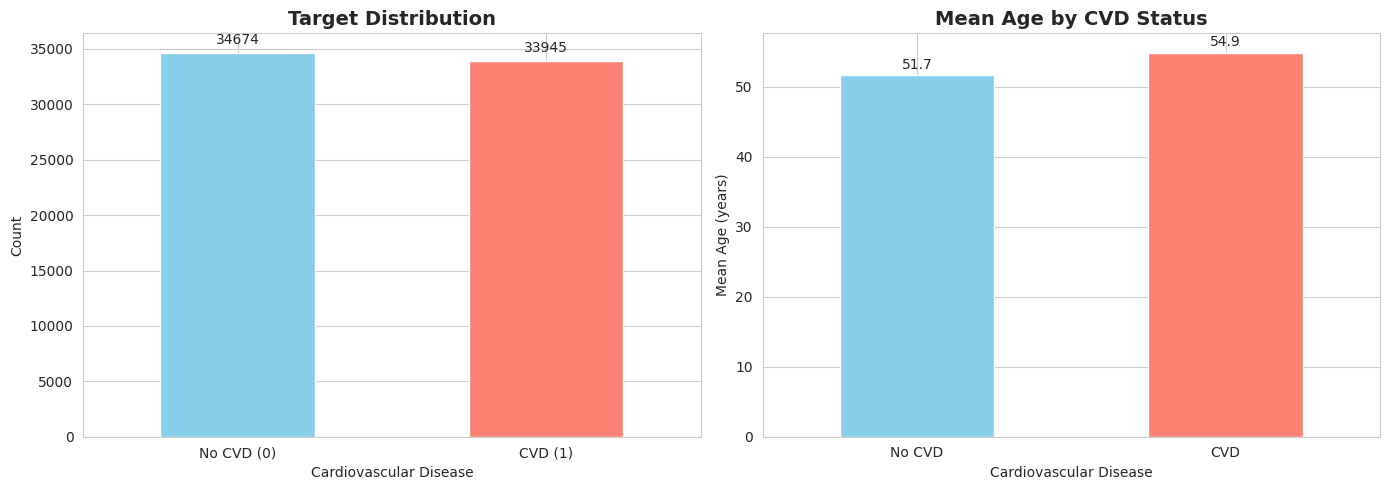

 Saved: 02_feature_distributions.png


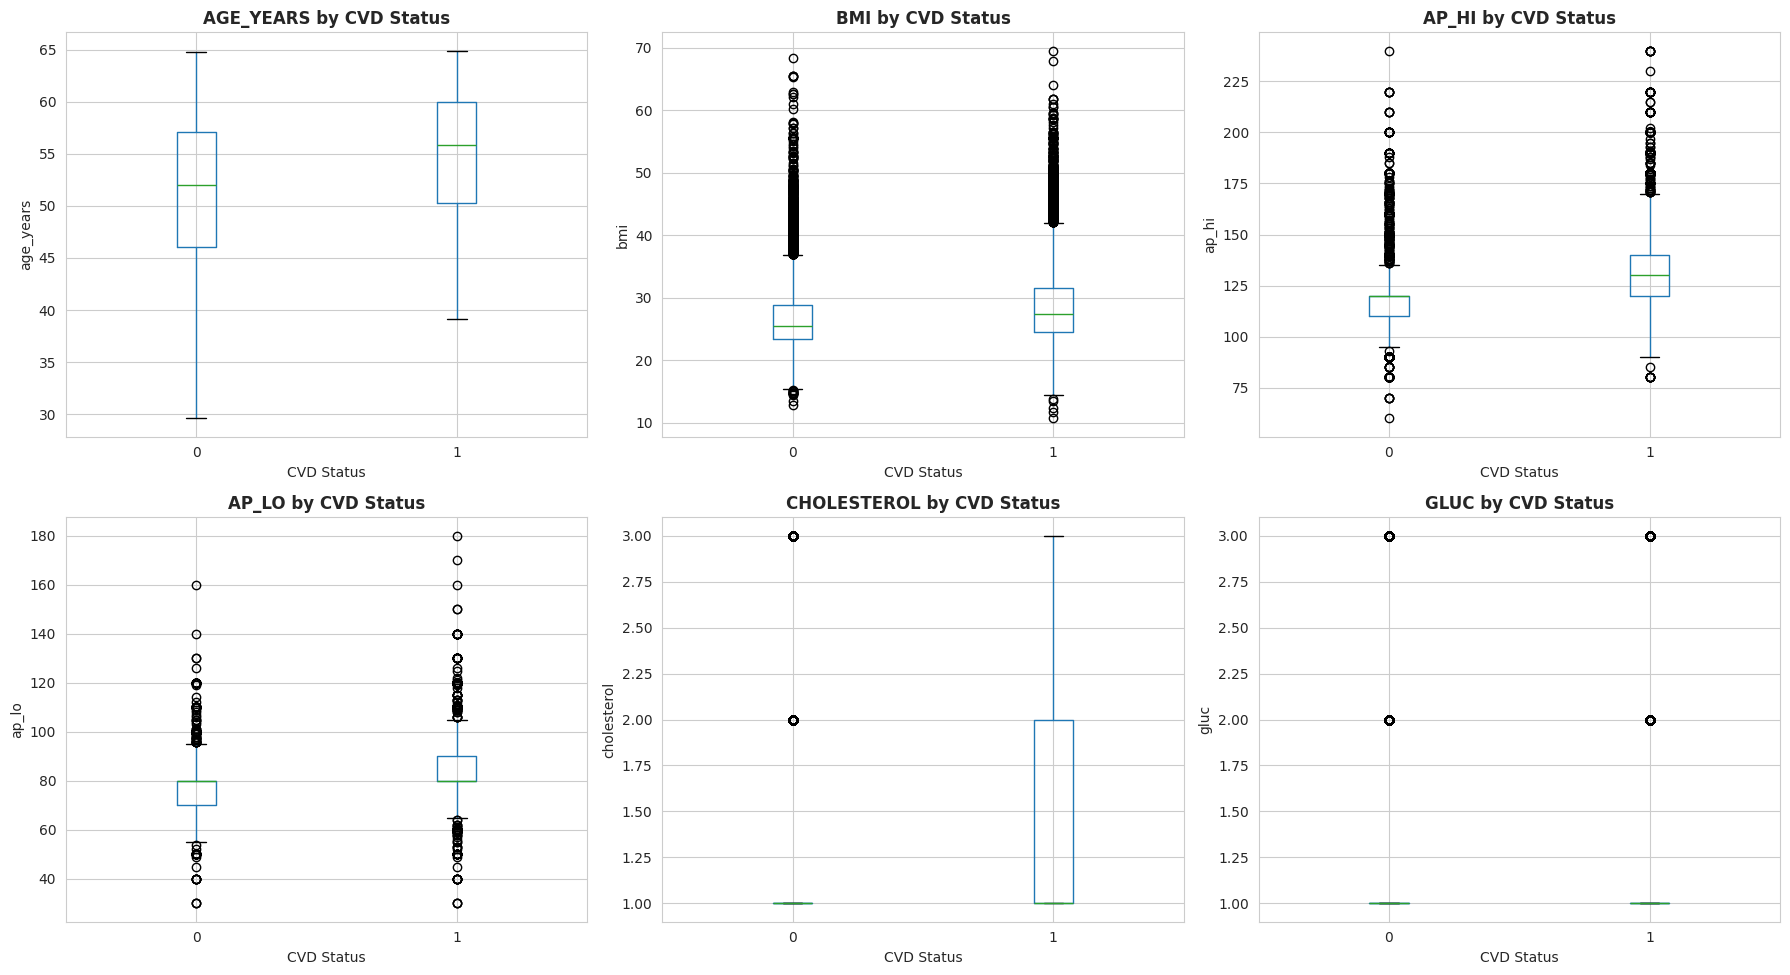

 Saved: 03_correlation_matrix.png


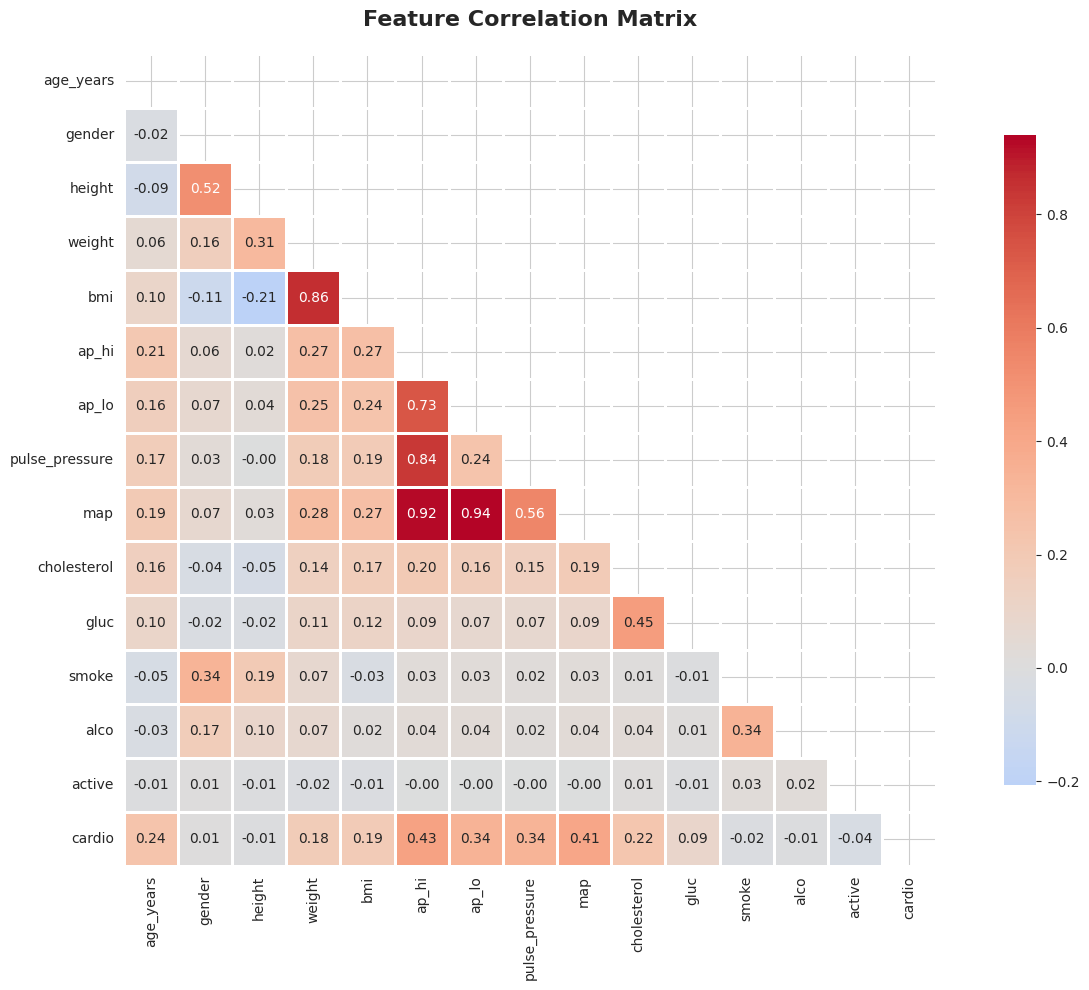

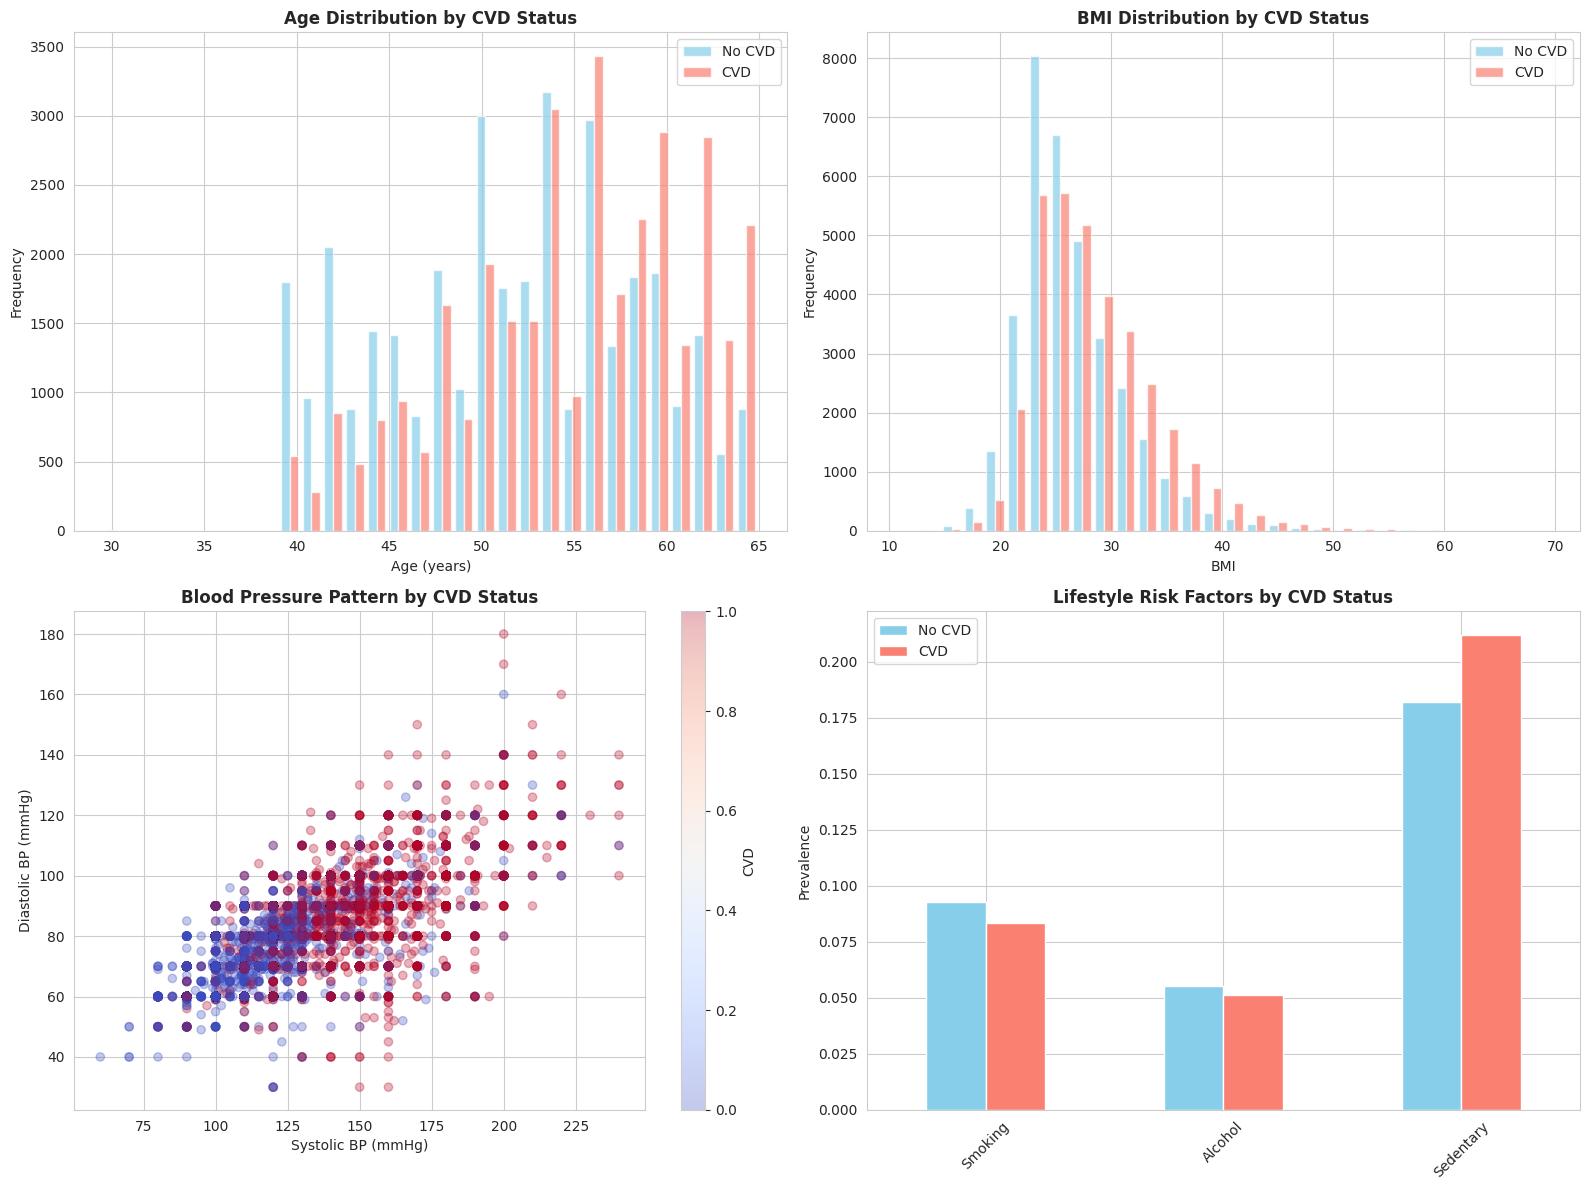

In [55]:
# =============================================================================
# CELL: Exploratory Data Analysis - Visualizations
# =============================================================================

print("\n[6] Generating visualizations...")

# 6.1 Target distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Target Distribution plot
cardio_counts = df_clean['cardio'].value_counts()
cardio_counts.plot(kind='bar', ax=ax[0], color=['skyblue', 'salmon'])
ax[0].set_title('Target Distribution', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Cardiovascular Disease')
ax[0].set_ylabel('Count')
ax[0].set_xticklabels(['No CVD (0)', 'CVD (1)'], rotation=0)
for index, value in enumerate(cardio_counts):
    ax[0].text(index, value + 500, str(value), ha='center', va='bottom')

# Mean Age by CVD Status plot
age_mean_by_cardio = df_clean.groupby('cardio')['age_years'].mean()
age_mean_by_cardio.plot(kind='bar', ax=ax[1], color=['skyblue', 'salmon'])
ax[1].set_title('Mean Age by CVD Status', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Cardiovascular Disease')
ax[1].set_ylabel('Mean Age (years)')
ax[1].set_xticklabels(['No CVD', 'CVD'], rotation=0)
for index, value in enumerate(age_mean_by_cardio):
    ax[1].text(index, value + 0.5, f'{value:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 6.2 Feature distributions by target
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

features = ['age_years', 'bmi', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc']
for i, feature in enumerate(features):
    df_clean.boxplot(column=feature, by='cardio', ax=axes[i])
    axes[i].set_title(f'{feature.upper()} by CVD Status', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('CVD Status')
    axes[i].set_ylabel(feature)

plt.suptitle('')
plt.tight_layout()
plt.savefig('/02_feature_distributions.png', dpi=150, bbox_inches='tight')
print(" Saved: 02_feature_distributions.png")
plt.show()

# 6.3 Correlation heatmap
plt.figure(figsize=(14, 10))
corr_features = ['age_years', 'gender', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo',
                 'pulse_pressure', 'map', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']
corr = df_clean[corr_features].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('/03_correlation_matrix.png', dpi=150, bbox_inches='tight')
print(" Saved: 03_correlation_matrix.png")
plt.show()

# 6.4 Key insights visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Age distribution by CVD
axes[0, 0].hist([df_clean[df_clean['cardio']==0]['age_years'],
                 df_clean[df_clean['cardio']==1]['age_years']],
                bins=30, label=['No CVD', 'CVD'], alpha=0.7, color=['skyblue', 'salmon'])
axes[0, 0].set_xlabel('Age (years)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Age Distribution by CVD Status', fontweight='bold')
axes[0, 0].legend()

# BMI distribution by CVD
axes[0, 1].hist([df_clean[df_clean['cardio']==0]['bmi'],
                 df_clean[df_clean['cardio']==1]['bmi']],
                bins=30, label=['No CVD', 'CVD'], alpha=0.7, color=['skyblue', 'salmon'])
axes[0, 1].set_xlabel('BMI')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('BMI Distribution by CVD Status', fontweight='bold')
axes[0, 1].legend()

# BP scatter
scatter = axes[1, 0].scatter(df_clean['ap_hi'], df_clean['ap_lo'],
                            c=df_clean['cardio'], alpha=0.3, cmap='coolwarm')
axes[1, 0].set_xlabel('Systolic BP (mmHg)')
axes[1, 0].set_ylabel('Diastolic BP (mmHg)')
axes[1, 0].set_title('Blood Pressure Pattern by CVD Status', fontweight='bold')
plt.colorbar(scatter, ax=axes[1, 0], label='CVD')

# Lifestyle factors
lifestyle_data = pd.DataFrame({
    'No CVD': [
        df_clean[df_clean['cardio']==0]['smoke'].mean(),
        df_clean[df_clean['cardio']==0]['alco'].mean(),
        1 - df_clean[df_clean['cardio']==0]['active'].mean()
    ],
    'CVD': [
        df_clean[df_clean['cardio']==1]['smoke'].mean(),
        df_clean[df_clean['cardio']==1]['alco'].mean(),
        1 - df_clean[df_clean['cardio']==1]['active'].mean()
    ]
}, index=['Smoking', 'Alcohol', 'Sedentary'])

lifestyle_data.plot(kind='bar', ax=axes[1, 1], color=['skyblue', 'salmon'])
axes[1, 1].set_ylabel('Prevalence')
axes[1, 1].set_title('Lifestyle Risk Factors by CVD Status', fontweight='bold')
axes[1, 1].set_xticklabels(lifestyle_data.index, rotation=45)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [56]:
# =============================================================================
# CELL: Prepare Features for Modeling
# =============================================================================

print("\n[7] Preparing features for modeling...")

# Define feature set
feature_columns = [
    'gender', 'age_years', 'height', 'weight', 'bmi',
    'ap_hi', 'ap_lo', 'pulse_pressure', 'map',
    'cholesterol', 'gluc', 'smoke', 'alco', 'active'
]

X = df_clean[feature_columns].copy()
y = df_clean['cardio'].copy()

print(f" Feature matrix: {X.shape}")
print(f" Target vector: {y.shape}")
print(f"\nFeatures used: {feature_columns}")


[7] Preparing features for modeling...
 Feature matrix: (68619, 14)
 Target vector: (68619,)

Features used: ['gender', 'age_years', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo', 'pulse_pressure', 'map', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']


In [57]:
# =============================================================================
# CELL: Train/Validation/Test Split
# =============================================================================

print("\n[8] Splitting data...")

# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Second split: 15% validation, 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f" Training set:   {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f" Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f" Test set:       {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nClass balance check:")
print(f"  Train:      {y_train.sum()/len(y_train)*100:.1f}% CVD")
print(f"  Validation: {y_val.sum()/len(y_val)*100:.1f}% CVD")
print(f"  Test:       {y_test.sum()/len(y_test)*100:.1f}% CVD")


[8] Splitting data...
 Training set:   48,033 samples (70.0%)
 Validation set: 10,293 samples (15.0%)
 Test set:       10,293 samples (15.0%)

Class balance check:
  Train:      49.5% CVD
  Validation: 49.5% CVD
  Test:       49.5% CVD


In [58]:
# =============================================================================
# CELL: Feature Scaling
# =============================================================================

print("\n[9] Scaling features...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(" Features scaled using StandardScaler")
print(f"  Mean: {X_train_scaled.mean(axis=0).round(2)}")
print(f"  Std:  {X_train_scaled.std(axis=0).round(2)}")


[9] Scaling features...
 Features scaled using StandardScaler
  Mean: [ 0.  0. -0.  0. -0. -0. -0. -0.  0. -0. -0. -0.  0. -0.]
  Std:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [59]:
# =============================================================================
# CELL: Save Processed Data
# =============================================================================

print("\n[10] Saving processed data...")

# Use OUTPUT_PATH
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Save clean full dataset
clean_data_path = os.path.join(OUTPUT_PATH, 'cardio_clean.csv')
df_clean.to_csv(clean_data_path, index=False)
print(f" Saved: {clean_data_path}")

# Save train/val/test splits
X_train.to_csv(os.path.join(OUTPUT_PATH, 'X_train.csv'), index=False)
X_val.to_csv(os.path.join(OUTPUT_PATH, 'X_val.csv'), index=False)
X_test.to_csv(os.path.join(OUTPUT_PATH, 'X_test.csv'), index=False)
y_train.to_csv(os.path.join(OUTPUT_PATH, 'y_train.csv'), index=False, header=['cardio'])
y_val.to_csv(os.path.join(OUTPUT_PATH, 'y_val.csv'), index=False, header=['cardio'])
y_test.to_csv(os.path.join(OUTPUT_PATH, 'y_test.csv'), index=False, header=['cardio'])

print(f" Saved train/val/test splits to {OUTPUT_PATH}")

# Save scaled data
np.save(os.path.join(OUTPUT_PATH, 'X_train_scaled.npy'), X_train_scaled)
np.save(os.path.join(OUTPUT_PATH, 'X_val_scaled.npy'), X_val_scaled)
np.save(os.path.join(OUTPUT_PATH, 'X_test_scaled.npy'), X_test_scaled)

print(f" Saved scaled features to {OUTPUT_PATH}")

# Save scaler
scaler_path = os.path.join(OUTPUT_PATH, 'feature_scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f" Saved scaler: {scaler_path}")


[10] Saving processed data...
 Saved: /content/output/cardio_clean.csv
 Saved train/val/test splits to /content/output
 Saved scaled features to /content/output
 Saved scaler: /content/output/feature_scaler.pkl


In [ ]:
# =============================================================================
# CELL: Model Training - Logistic Regression (Baseline)
# =============================================================================

print("\n" + "="*80)
print("CARDIOVASCULAR RISK PREDICTION - MODEL TRAINING")
print("="*80)

print("\n[2] Training baseline: Logistic Regression...")

lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)

lr_model.fit(X_train_scaled, y_train)

# Evaluate on validation set
y_val_pred_lr = lr_model.predict(X_val_scaled)
y_val_prob_lr = lr_model.predict_proba(X_val_scaled)[:, 1]

lr_auc = roc_auc_score(y_val, y_val_prob_lr)
print(f" Logistic Regression Validation AUC: {lr_auc:.4f}")

# Feature importance (coefficients)
lr_coef = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print(f"\nTop 5 features (Logistic Regression):")
for idx, row in lr_coef.head().iterrows():
    print(f"  {row['feature']}: {row['coefficient']:.4f}")


BYTE2BEAT: CARDIOVASCULAR RISK PREDICTION - MODEL TRAINING

[2] Training baseline: Logistic Regression...
 Logistic Regression Validation AUC: 0.7871

Top 5 features (Logistic Regression):
  cholesterol: 0.3376
  ap_hi: 0.3310
  age_years: 0.3276
  pulse_pressure: 0.3258
  map: 0.3115


In [61]:
# =============================================================================
# CELL: Model Training - Initial XGBoost
# =============================================================================

print("\n[3] Training XGBoost model...")

xgb_initial = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    tree_method='hist'
)

xgb_initial.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

y_val_prob_xgb = xgb_initial.predict_proba(X_val)[:, 1]
xgb_initial_auc = roc_auc_score(y_val, y_val_prob_xgb)
print(f" XGBoost (initial) Validation AUC: {xgb_initial_auc:.4f}")


[3] Training XGBoost model...
 XGBoost (initial) Validation AUC: 0.7941


In [62]:
# =============================================================================
# CELL: Hyperparameter Tuning
# =============================================================================

print("\n[4] Hyperparameter tuning with RandomizedSearchCV...")

param_distributions = {
    'n_estimators': [100, 300, 500, 700, 1000],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1, 0.15],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 2, 3, 5, 7],
    'reg_alpha': [0, 0.01, 0.1, 0.5, 1.0],
    'reg_lambda': [0.5, 1.0, 1.5, 2.0, 3.0]
}

xgb_base = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    tree_method='hist',
    early_stopping_rounds=50
)

xgb_random = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print("Running randomized search...")
fit_params = {'eval_set': [(X_val, y_val)], 'verbose': False}
xgb_random.fit(X_train, y_train, **fit_params)

print(f"\n Best CV AUC: {xgb_random.best_score_:.4f}")
print(f" Best parameters:")
for param, value in xgb_random.best_params_.items():
    print(f"  {param}: {value}")

best_xgb = xgb_random.best_estimator_


[4] Hyperparameter tuning with RandomizedSearchCV...
Running randomized search...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

 Best CV AUC: 0.7997
 Best parameters:
  subsample: 0.9
  reg_lambda: 2.0
  reg_alpha: 1.0
  n_estimators: 700
  min_child_weight: 2
  max_depth: 4
  learning_rate: 0.01
  gamma: 0.2
  colsample_bytree: 0.7


In [63]:
# =============================================================================
# CELL: Cross-Validation for XGBoost
# =============================================================================

print("\n[2.5] Cross-validation for robust model comparison...")
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nPerforming 5-fold CV for XGBoost...")

if 'best_xgb' in locals():
    xgb_params = best_xgb.get_params()
    xgb_params.pop('early_stopping_rounds', None)
    xgb_cv_model = xgb.XGBClassifier(**xgb_params)
else:
    xgb_cv_model = xgb.XGBClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, random_state=42,
        eval_metric='logloss', tree_method='hist',
        early_stopping_rounds=None
    )

xgb_cv_scores = cross_val_score(
    xgb_cv_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1
)
print(f" XGBoost CV AUC: {xgb_cv_scores.mean():.4f} (+/- {xgb_cv_scores.std()*2:.4f})")

print("\nCROSS-VALIDATION SUMMARY (5-fold)")
print(f"XGBoost:             {xgb_cv_scores.mean():.4f} (\u00b1{xgb_cv_scores.std()*2:.4f})")


[2.5] Cross-validation for robust model comparison...

Performing 5-fold CV for XGBoost...
 XGBoost CV AUC: 0.8000 (+/- 0.0045)

CROSS-VALIDATION SUMMARY (5-fold)
XGBoost:             0.8000 (±0.0045)


In [64]:
# =============================================================================
# CELL: Final Evaluation on Test Set
# =============================================================================

print("\n[5] Final evaluation on test set...")

y_test_pred_lr = lr_model.predict(X_test_scaled)
y_test_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

y_test_pred_xgb = best_xgb.predict(X_test)
y_test_prob_xgb = best_xgb.predict_proba(X_test)[:, 1]

results = {
    'Logistic Regression': {
        'AUC-ROC': roc_auc_score(y_test, y_test_prob_lr),
        'Precision': classification_report(y_test, y_test_pred_lr, output_dict=True)['1']['precision'],
        'Recall': classification_report(y_test, y_test_pred_lr, output_dict=True)['1']['recall'],
        'F1-Score': classification_report(y_test, y_test_pred_lr, output_dict=True)['1']['f1-score']
    },
    'XGBoost': {
        'AUC-ROC': roc_auc_score(y_test, y_test_prob_xgb),
        'Precision': classification_report(y_test, y_test_pred_xgb, output_dict=True)['1']['precision'],
        'Recall': classification_report(y_test, y_test_pred_xgb, output_dict=True)['1']['recall'],
        'F1-Score': classification_report(y_test, y_test_pred_xgb, output_dict=True)['1']['f1-score']
    }
}

results_df = pd.DataFrame(results).T
print("\nTest Set Performance:")
print(results_df.round(4))

print("\n" + "=" * 80)
print("XGBOOST CLASSIFICATION REPORT (Test Set)")
print("=" * 80)
print(classification_report(y_test, y_test_pred_xgb, target_names=['No CVD', 'CVD']))


[5] Final evaluation on test set...

Test Set Performance:
                     AUC-ROC  Precision  Recall  F1-Score
Logistic Regression   0.7996     0.7628  0.6714    0.7142
XGBoost               0.8118     0.7712  0.6897    0.7282

XGBOOST CLASSIFICATION REPORT (Test Set)
              precision    recall  f1-score   support

      No CVD       0.72      0.80      0.76      5201
         CVD       0.77      0.69      0.73      5092

    accuracy                           0.75     10293
   macro avg       0.75      0.74      0.74     10293
weighted avg       0.75      0.75      0.74     10293




[6] Generating ROC curves...


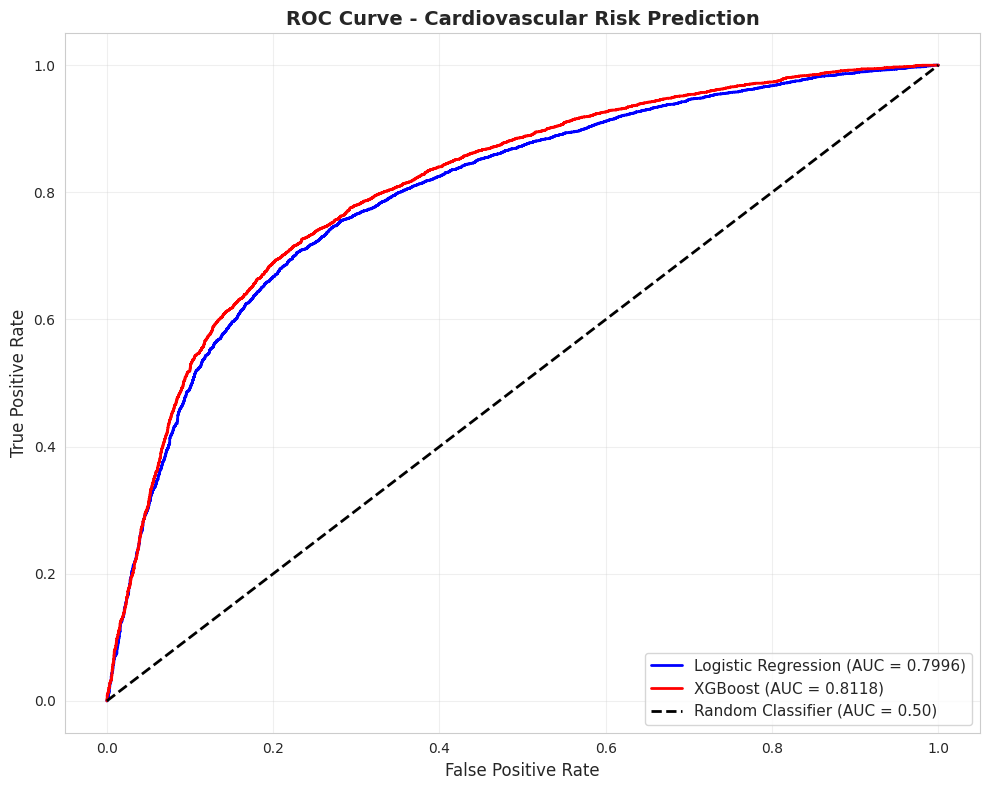

In [65]:
# =============================================================================
# CELL: ROC Curve
# =============================================================================

print("\n[6] Generating ROC curves...")

fig, ax = plt.subplots(figsize=(10, 8))

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_test_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
ax.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})',
        linewidth=2, color='blue')

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
ax.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})',
        linewidth=2, color='red')

ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.50)')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve - Cardiovascular Risk Prediction', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


[7] Generating Precision-Recall curves...


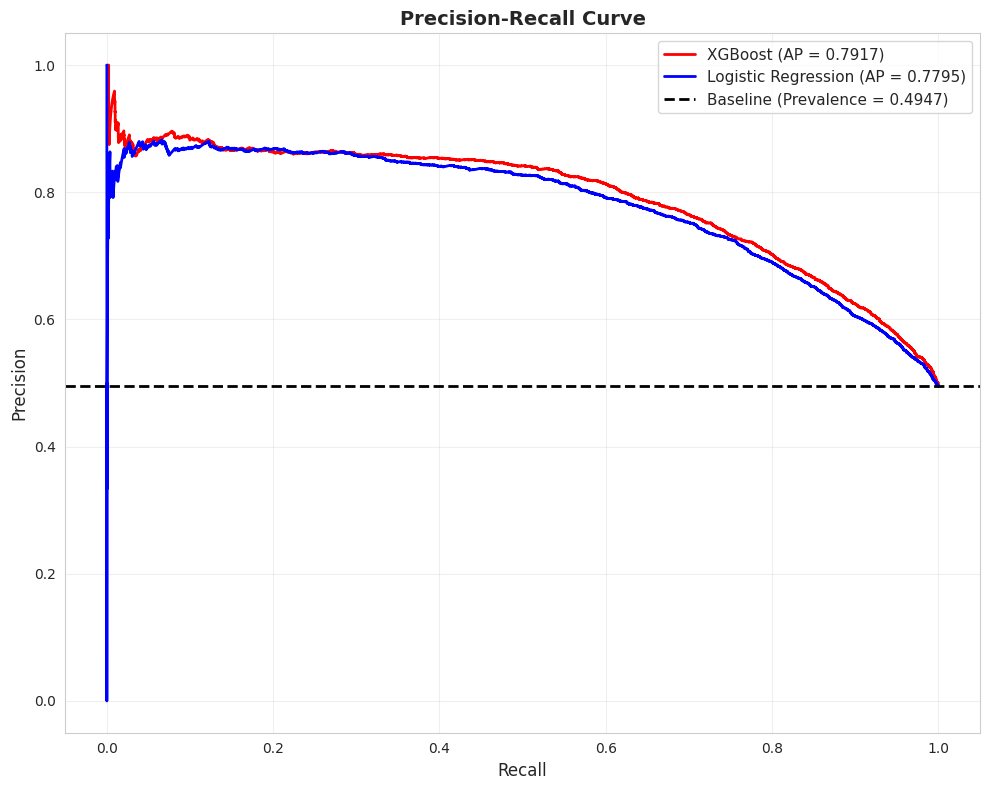

In [66]:
# =============================================================================
# CELL: Precision-Recall Curve
# =============================================================================

print("\n[7] Generating Precision-Recall curves...")

fig, ax = plt.subplots(figsize=(10, 8))

precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_test_prob_xgb)
ap_xgb = average_precision_score(y_test, y_test_prob_xgb)
ax.plot(recall_xgb, precision_xgb, label=f'XGBoost (AP = {ap_xgb:.4f})',
        linewidth=2, color='red')

precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_test_prob_lr)
ap_lr = average_precision_score(y_test, y_test_prob_lr)
ax.plot(recall_lr, precision_lr, label=f'Logistic Regression (AP = {ap_lr:.4f})',
        linewidth=2, color='blue')

baseline = y_test.sum() / len(y_test)
ax.axhline(y=baseline, color='k', linestyle='--', linewidth=2,
           label=f'Baseline (Prevalence = {baseline:.4f})')

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


[8] Generating confusion matrices...


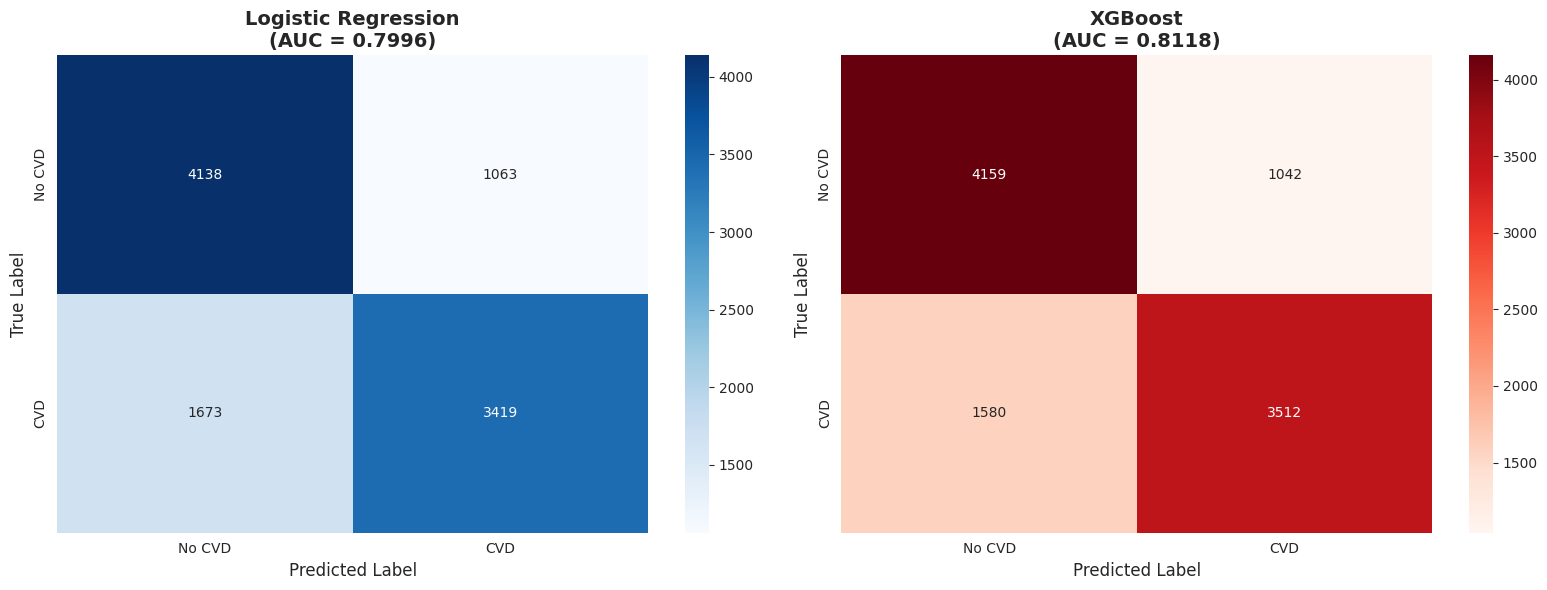

In [67]:
# =============================================================================
# CELL: Confusion Matrices
# =============================================================================

print("\n[8] Generating confusion matrices...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

cm_lr = confusion_matrix(y_test, y_test_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No CVD', 'CVD'], yticklabels=['No CVD', 'CVD'])
axes[0].set_title(f'Logistic Regression\n(AUC = {roc_auc_lr:.4f})',
                 fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Reds', ax=axes[1],
            xticklabels=['No CVD', 'CVD'], yticklabels=['No CVD', 'CVD'])
axes[1].set_title(f'XGBoost\n(AUC = {roc_auc_xgb:.4f})',
                 fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

In [68]:
# =============================================================================
# CELL: Cost-Sensitive XGBoost Model Training
# =============================================================================

from sklearn.metrics import recall_score, precision_score, f1_score
print("\n[5.6] Training cost-sensitive XGBoost model...")

neg_pos_ratio = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Negative:Positive ratio in training: {neg_pos_ratio:.2f}")

print("\nEvaluating different scale_pos_weight values...")
weight_options = [1, neg_pos_ratio, neg_pos_ratio * 1.5, neg_pos_ratio * 2]
weight_results = []

for weight in weight_options:
    base_params = {k: v for k, v in best_xgb.get_params().items()
                   if k not in ['scale_pos_weight', 'random_state', 'early_stopping_rounds']}

    xgb_weighted = xgb.XGBClassifier(
        **base_params,
        scale_pos_weight=weight,
        random_state=42
    )

    xgb_weighted.fit(X_train, y_train)
    y_val_pred = xgb_weighted.predict(X_val)

    weight_results.append({
        'scale_pos_weight': weight,
        'recall': recall_score(y_val, y_val_pred),
        'precision': precision_score(y_val, y_val_pred),
        'f1': f1_score(y_val, y_val_pred),
        'false_negatives': confusion_matrix(y_val, y_val_pred)[1, 0]
    })

weight_df = pd.DataFrame(weight_results)
print("\nResults on validation set:")
print(weight_df.to_string(index=False))

best_weight_row = weight_df.loc[weight_df['recall'].idxmax()]
best_weight = best_weight_row['scale_pos_weight']

print(f"\nBest scale_pos_weight: {best_weight}")
print(f"  - Recall: {best_weight_row['recall']:.4f}")
print(f"  - Precision: {best_weight_row['precision']:.4f}")

final_model_params = {k: v for k, v in best_xgb.get_params().items()
                      if k not in ['scale_pos_weight', 'random_state', 'early_stopping_rounds']}

xgb_cost_sensitive = xgb.XGBClassifier(
    **final_model_params,
    scale_pos_weight=best_weight,
    random_state=42
)

xgb_cost_sensitive.fit(X_train, y_train)

y_test_pred_cost = xgb_cost_sensitive.predict(X_test)
y_test_prob_cost = xgb_cost_sensitive.predict_proba(X_test)[:, 1]

print("\n" + "="*60)
print("COST-SENSITIVE MODEL - TEST SET PERFORMANCE")
print("="*60)
print(classification_report(y_test, y_test_pred_cost, target_names=['No CVD', 'CVD']))

cm_cost = confusion_matrix(y_test, y_test_pred_cost)
print(f"False Negatives: {cm_cost[1, 0]}")


[5.6] Training cost-sensitive XGBoost model...
Negative:Positive ratio in training: 1.02

Evaluating different scale_pos_weight values...

Results on validation set:
 scale_pos_weight   recall  precision       f1  false_negatives
         1.000000 0.677141   0.757636 0.715130             1644
         1.021506 0.683818   0.754169 0.717273             1610
         1.532259 0.772977   0.695898 0.732415             1156
         2.043012 0.846229   0.645930 0.732636              783

Best scale_pos_weight: 2.043011657758512
  - Recall: 0.8462
  - Precision: 0.6459

COST-SENSITIVE MODEL - TEST SET PERFORMANCE
              precision    recall  f1-score   support

      No CVD       0.80      0.56      0.66      5201
         CVD       0.66      0.86      0.75      5092

    accuracy                           0.71     10293
   macro avg       0.73      0.71      0.71     10293
weighted avg       0.73      0.71      0.70     10293

False Negatives: 712


In [69]:
# =============================================================================
# CELL: Cross-Validation for Cost-Sensitive Model
# =============================================================================

print("\n[13] Cross-validation for robust model comparison...")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nPerforming 5-fold CV for Cost-Sensitive XGBoost...")
xgb_params = xgb_cost_sensitive.get_params()
xgb_params.pop('early_stopping_rounds', None)
xgb_cv_model = xgb.XGBClassifier(**xgb_params)

xgb_cv_scores_cost = cross_val_score(
    xgb_cv_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1
)
print(f" XGBoost CV AUC: {xgb_cv_scores_cost.mean():.4f} (+/- {xgb_cv_scores_cost.std()*2:.4f})")

print("\n" + "="*60)
print("CROSS-VALIDATION SUMMARY")
print("="*60)
print(f"XGBoost:             {xgb_cv_scores_cost.mean():.4f} (\u00b1{xgb_cv_scores_cost.std()*2:.4f})")


[13] Cross-validation for robust model comparison...

Performing 5-fold CV for Cost-Sensitive XGBoost...
 XGBoost CV AUC: 0.8000 (+/- 0.0045)

CROSS-VALIDATION SUMMARY
XGBoost:             0.8000 (±0.0045)


In [70]:
# =============================================================================
# CELL: Cost-Sensitive Model - Test Set Evaluation
# =============================================================================

print("\n[14] Final evaluation on test set...")

results_cost = {
    'Cost-Sensitive XGBoost': {
        'AUC-ROC': roc_auc_score(y_test, y_test_prob_cost),
        'Precision': classification_report(y_test, y_test_pred_cost, output_dict=True)['1']['precision'],
        'Recall': classification_report(y_test, y_test_pred_cost, output_dict=True)['1']['recall'],
        'F1-Score': classification_report(y_test, y_test_pred_cost, output_dict=True)['1']['f1-score']
    }
}

results_cost_df = pd.DataFrame(results_cost).T
print("\nTest Set Performance:")
results_cost_df.round(4)


[14] Final evaluation on test set...

Test Set Performance:


,AUC-ROC,Precision,Recall,F1-Score
Cost-Sensitive XGBoost,0.8117,0.6593,0.8602,0.7465



[15] Analyzing feature importance...

Cost-Sensitive XGBoost Feature Importance (Top 10):
       feature  importance
         ap_hi    0.415760
           map    0.157423
         ap_lo    0.098264
   cholesterol    0.087154
     age_years    0.067904
pulse_pressure    0.066204
        active    0.023476
         smoke    0.017292
        weight    0.014508
           bmi    0.014449


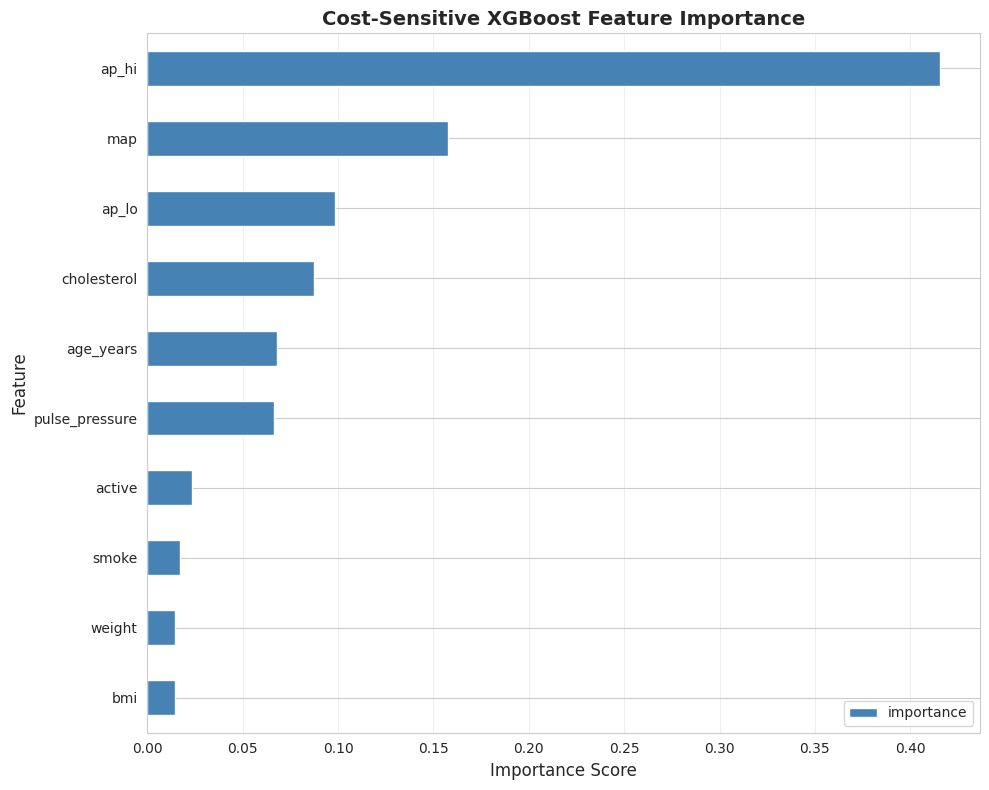

In [71]:
# =============================================================================
# CELL: Feature Importance Analysis
# =============================================================================

print("\n[15] Analyzing feature importance...")

importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_cost_sensitive.feature_importances_
}).sort_values('importance', ascending=False)

print("\nCost-Sensitive XGBoost Feature Importance (Top 10):")
print(importance_df.head(10).to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 8))
importance_df.head(10).plot(x='feature', y='importance', kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Cost-Sensitive XGBoost Feature Importance', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


[16] SHAP Analysis for model interpretability...


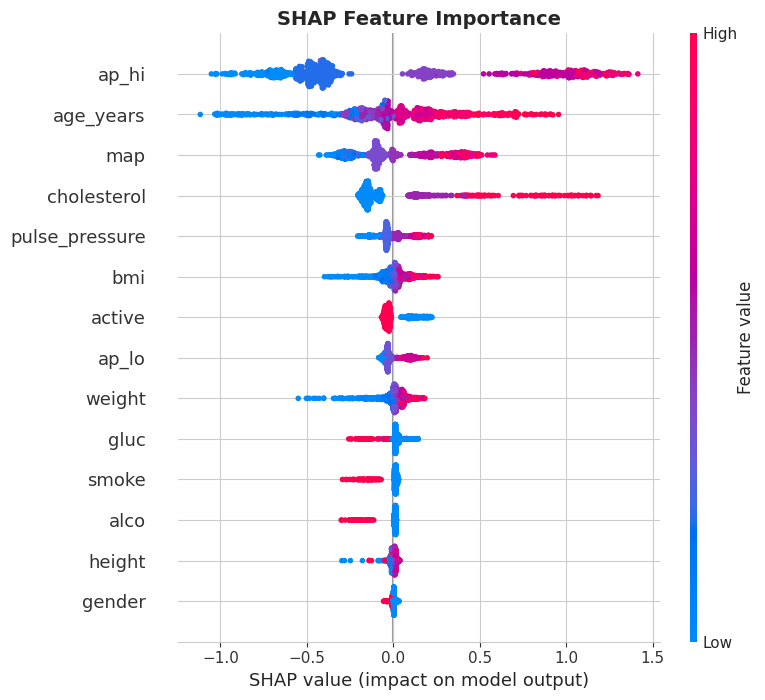

In [72]:
# =============================================================================
# CELL: SHAP Analysis
# =============================================================================

print("\n[16] SHAP Analysis for model interpretability...")

X_train_sample = X_train.sample(n=min(1000, len(X_train)), random_state=42)
explainer = shap.TreeExplainer(xgb_cost_sensitive)
shap_values = explainer.shap_values(X_train_sample)

fig, ax = plt.subplots(figsize=(12, 8))
shap.summary_plot(shap_values, X_train_sample, plot_type="dot", show=False)
plt.title('SHAP Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [73]:
# =============================================================================
# CELL: Save Cost-Sensitive Model
# =============================================================================

print("\n[17] Saving cost-sensitive model with metadata...")

# Use OUTPUT_PATH instead of output_dir
model_metadata = {
    'model': xgb_cost_sensitive,
    'model_type': 'Cost-Sensitive XGBoost',
    'scale_pos_weight': best_weight,
    'test_metrics': {
        'auc_roc': results_cost['Cost-Sensitive XGBoost']['AUC-ROC'],
        'precision': results_cost['Cost-Sensitive XGBoost']['Precision'],
        'recall': results_cost['Cost-Sensitive XGBoost']['Recall'],
        'f1_score': results_cost['Cost-Sensitive XGBoost']['F1-Score']
    },
    'cv_results': {
        'mean_auc': xgb_cv_scores_cost.mean(),
        'std_auc': xgb_cv_scores_cost.std(),
        'scores': xgb_cv_scores_cost.tolist()
    },
    'feature_importance': importance_df.set_index('feature')['importance'].to_dict(),
    'features': list(X_train.columns),
    'confusion_matrix': cm_cost.tolist(),
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'random_state': seed_value  # Use seed_value variable
}

# Save full model with metadata
full_model_path = os.path.join(OUTPUT_PATH, 'cost_sensitive_xgboost_model.pkl')
joblib.dump(model_metadata, full_model_path)
print(f" Saved: {full_model_path}")

# Save simplified deployment model
simple_model = {
    'model': xgb_cost_sensitive,
    'features': list(X_train.columns),
    'scale_pos_weight': best_weight,
    'random_seed': seed_value  # Add seed for reproducibility
}

deployment_model_path = os.path.join(OUTPUT_PATH, 'deployment_model.pkl')
joblib.dump(simple_model, deployment_model_path)
print(f" Saved: {deployment_model_path}")


[17] Saving cost-sensitive model with metadata...
 Saved: /content/output/cost_sensitive_xgboost_model.pkl
 Saved: /content/output/deployment_model.pkl



[7.5] Generating comprehensive model performance dashboard (Cost-Sensitive XGBoost)...


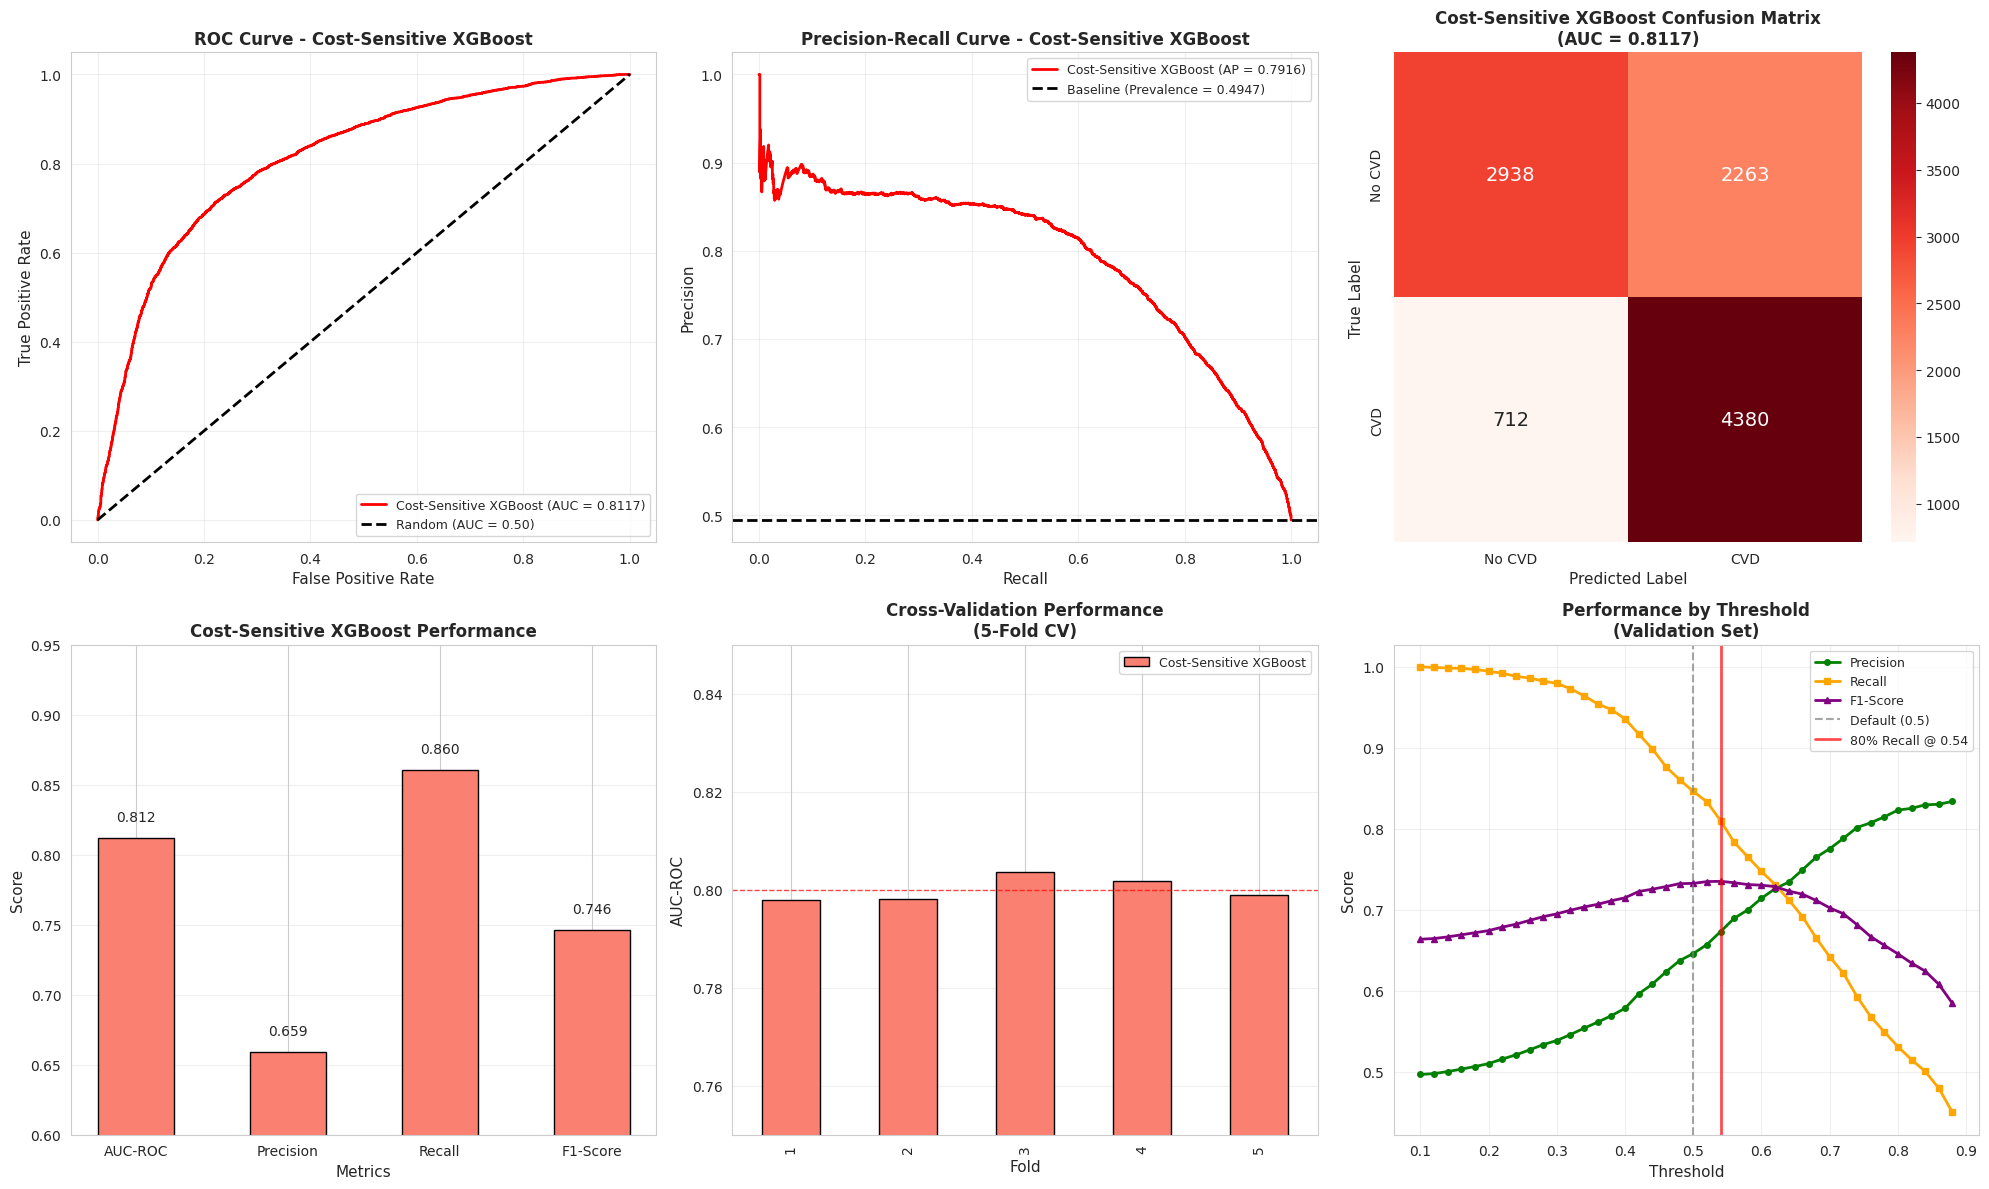

In [75]:
# =============================================================================
# CELL: Comprehensive Performance Dashboard
# =============================================================================

print("\n[7.5] Generating comprehensive model performance dashboard (Cost-Sensitive XGBoost)...")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. ROC Curve
fpr_cost, tpr_cost, _ = roc_curve(y_test, y_test_prob_cost)
roc_auc_cost = auc(fpr_cost, tpr_cost)

axes[0, 0].plot(fpr_cost, tpr_cost, label=f'Cost-Sensitive XGBoost (AUC = {roc_auc_cost:.4f})',
                linewidth=2, color='red')
axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random (AUC = 0.50)')
axes[0, 0].set_xlabel('False Positive Rate', fontsize=11)
axes[0, 0].set_ylabel('True Positive Rate', fontsize=11)
axes[0, 0].set_title('ROC Curve - Cost-Sensitive XGBoost', fontsize=12, fontweight='bold')
axes[0, 0].legend(loc='lower right', fontsize=9)
axes[0, 0].grid(True, alpha=0.3)

# 2. Precision-Recall Curve
precision_cost, recall_cost, _ = precision_recall_curve(y_test, y_test_prob_cost)
ap_cost = average_precision_score(y_test, y_test_prob_cost)

axes[0, 1].plot(recall_cost, precision_cost, label=f'Cost-Sensitive XGBoost (AP = {ap_cost:.4f})',
                linewidth=2, color='red')
axes[0, 1].axhline(y=baseline, color='k', linestyle='--', linewidth=2,
                   label=f'Baseline (Prevalence = {baseline:.4f})')
axes[0, 1].set_xlabel('Recall', fontsize=11)
axes[0, 1].set_ylabel('Precision', fontsize=11)
axes[0, 1].set_title('Precision-Recall Curve - Cost-Sensitive XGBoost', fontsize=12, fontweight='bold')
axes[0, 1].legend(loc='best', fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

# 3. Confusion Matrix
sns.heatmap(cm_cost, annot=True, fmt='d', cmap='Reds', ax=axes[0, 2],
            xticklabels=['No CVD', 'CVD'], yticklabels=['No CVD', 'CVD'],
            annot_kws={'size': 14})
axes[0, 2].set_title(f'Cost-Sensitive XGBoost Confusion Matrix\n(AUC = {roc_auc_cost:.4f})',
                     fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('True Label', fontsize=11)
axes[0, 2].set_xlabel('Predicted Label', fontsize=11)

# 4. Metrics bar chart
metrics = ['AUC-ROC', 'Precision', 'Recall', 'F1-Score']
cost_scores = [
    roc_auc_cost,
    precision_score(y_test, y_test_pred_cost),
    recall_score(y_test, y_test_pred_cost),
    f1_score(y_test, y_test_pred_cost)
]

x = np.arange(len(metrics))
width = 0.5

bars = axes[1, 0].bar(x, cost_scores, width, label='Cost-Sensitive XGBoost',
                      color='salmon', edgecolor='black', linewidth=1)

for bar in bars:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=10)

axes[1, 0].set_xlabel('Metrics', fontsize=11)
axes[1, 0].set_ylabel('Score', fontsize=11)
axes[1, 0].set_title('Cost-Sensitive XGBoost Performance', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(metrics)
axes[1, 0].set_ylim(0.6, 0.95)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 5. Cross-validation stability plot
if 'xgb_cv_scores_cost' in locals():
    cv_results = pd.DataFrame({
        'Fold': range(1, 6),
        'Cost-Sensitive XGBoost': xgb_cv_scores_cost
    })
    cv_results.plot(x='Fold', y=['Cost-Sensitive XGBoost'],
                    kind='bar', ax=axes[1, 1], color=['salmon'],
                    edgecolor='black', linewidth=1)
    axes[1, 1].set_title('Cross-Validation Performance\n(5-Fold CV)',
                         fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('AUC-ROC', fontsize=11)
    axes[1, 1].set_xlabel('Fold', fontsize=11)
    axes[1, 1].legend(fontsize=9)
    axes[1, 1].set_ylim(0.75, 0.85)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    axes[1, 1].axhline(y=xgb_cv_scores_cost.mean(), color='red', linestyle='--',
                       linewidth=1, alpha=0.7, label=f"Mean: {xgb_cv_scores_cost.mean():.4f}")
else:
    axes[1, 1].text(0.5, 0.5, 'Cross-validation results\nnot available',
                    ha='center', va='center', transform=axes[1, 1].transAxes,
                    fontsize=12, style='italic')
    axes[1, 1].set_title('Cross-Validation', fontsize=12, fontweight='bold')
    axes[1, 1].axis('on')

# 6. Threshold analysis (using validation set)
thresholds = np.arange(0.1, 0.9, 0.02)
metrics_threshold = []
for thresh in thresholds:
    y_pred = (xgb_cost_sensitive.predict_proba(X_val)[:, 1] >= thresh).astype(int)
    metrics_threshold.append({
        'threshold': thresh,
        'precision': precision_score(y_val, y_pred),
        'recall': recall_score(y_val, y_pred),
        'f1': f1_score(y_val, y_pred)
    })
df_temp = pd.DataFrame(metrics_threshold)

axes[1, 2].plot(df_temp['threshold'], df_temp['precision'],
                label='Precision', marker='o', linewidth=2, color='green', markersize=4)
axes[1, 2].plot(df_temp['threshold'], df_temp['recall'],
                label='Recall', marker='s', linewidth=2, color='orange', markersize=4)
axes[1, 2].plot(df_temp['threshold'], df_temp['f1'],
                label='F1-Score', marker='^', linewidth=2, color='purple', markersize=4)
axes[1, 2].axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, label='Default (0.5)')

target_recall = 0.80
optimal_idx = np.argmin(np.abs(df_temp['recall'] - target_recall))
optimal_thresh_val = df_temp.iloc[optimal_idx]['threshold']
axes[1, 2].axvline(x=optimal_thresh_val, color='red', linestyle='-', linewidth=2,
                   alpha=0.7, label=f'80% Recall @ {optimal_thresh_val:.2f}')

axes[1, 2].set_xlabel('Threshold', fontsize=11)
axes[1, 2].set_ylabel('Score', fontsize=11)
axes[1, 2].set_title('Performance by Threshold\n(Validation Set)',
                     fontsize=12, fontweight='bold')
axes[1, 2].legend(fontsize=9)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [76]:
# =============================================================================
# CELL: Summary Statistics
# =============================================================================

print("\n" + "="*60)
print("COST-SENSITIVE XGBOOST - SUMMARY STATISTICS")
print("="*60)
print(f"AUC-ROC: {roc_auc_cost:.4f}")
print(f"Average Precision (AP): {ap_cost:.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_cost):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred_cost):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred_cost):.4f}")
print(f"\nConfusion Matrix:")
print(f"  True Negatives:  {cm_cost[0, 0]}")
print(f"  False Positives: {cm_cost[0, 1]}")
print(f"  False Negatives: {cm_cost[1, 0]}")
print(f"  True Positives:  {cm_cost[1, 1]}")
print(f"\nCross-Validation Mean AUC: {xgb_cv_scores_cost.mean():.4f} (\u00b1{xgb_cv_scores_cost.std()*2:.4f})")
print("="*60)


COST-SENSITIVE XGBOOST - SUMMARY STATISTICS
AUC-ROC: 0.8117
Average Precision (AP): 0.7916
Precision: 0.6593
Recall: 0.8602
F1-Score: 0.7465

Confusion Matrix:
  True Negatives:  2938
  False Positives: 2263
  False Negatives: 712
  True Positives:  4380

Cross-Validation Mean AUC: 0.8000 (±0.0045)


In [77]:
# =============================================================================
# CELL: Test Model on New Patient with Detailed Risk Factors
# =============================================================================

print("\n" + "="*80)
print("TESTING MODEL ON NEW PATIENTS WITH DETAILED ANALYSIS")
print("="*80)

# Define model, explainer, and features for this cell's scope
model = xgb_cost_sensitive
explainer = shap.TreeExplainer(model)
features = list(X.columns)

def test_new_patient_with_details(patient_data, threshold=0.5, top_n=5, return_json=False):
    """
    Test a single new patient with detailed risk factors including SHAP analysis
    """
    missing_features = set(features) - set(patient_data.keys())
    if missing_features:
        raise ValueError(f"Missing features: {missing_features}")

    input_data = {feature: patient_data[feature] for feature in features}
    df = pd.DataFrame([input_data])[features]

    risk_score = float(model.predict_proba(df)[0, 1])
    prediction = 1 if risk_score >= threshold else 0
    risk_category = "HIGH" if prediction == 1 else "LOW"

    print("Calculating SHAP values for interpretation...")
    shap_values = explainer.shap_values(df)[0]

    feature_importance = dict(zip(features, model.feature_importances_))

    all_risk_factors = []
    for i, feature in enumerate(features):
        value = input_data[feature]

        if isinstance(value, (np.integer, np.int32, np.int64)):
            value_display = int(value)
        elif isinstance(value, (np.floating, np.float32, np.float64)):
            value_display = float(value)
        else:
            value_display = value

        risk_factor = {
            'feature': feature,
            'feature_name': get_feature_name(feature),
            'value': value_display,
            'unit': get_feature_unit(feature),
            'importance': float(feature_importance[feature]),
            'shap_value': float(shap_values[i]),
            'impact': 'increases risk' if shap_values[i] > 0 else 'decreases risk',
            'magnitude': abs(float(shap_values[i])),
            'interpretation': get_feature_interpretation(feature, value)
        }
        all_risk_factors.append(risk_factor)

    top_risk_factors = sorted(all_risk_factors, key=lambda x: x['magnitude'], reverse=True)[:top_n]

    for factor in top_risk_factors:
        del factor['magnitude']

    result = {
        'patient_id': patient_data.get('patient_id', 'unknown'),
        'risk_score': round(risk_score, 4),
        'prediction': int(prediction),
        'risk_category': risk_category,
        'threshold_used': float(threshold),
        'top_risk_factors': top_risk_factors,
        'feature_importance': [
            {'feature': f, 'importance': float(feature_importance[f])}
            for f in sorted(features, key=lambda x: feature_importance[x], reverse=True)[:10]
        ]
    }

    if return_json:
        return json.dumps(result, indent=2, cls=NumpyEncoder)

    return result

# Example 1: High-risk patient
patient_high = {
    'patient_id': 'P001',
    'gender': 1,
    'age_years': 62,
    'height': 165,
    'weight': 85,
    'bmi': 31.2,
    'ap_hi': 155,
    'ap_lo': 95,
    'pulse_pressure': 60,
    'map': 115.0,
    'cholesterol': 3,
    'gluc': 2,
    'smoke': 1,
    'alco': 1,
    'active': 0
}

# Example 2: Low-risk patient
patient_low = {
    'patient_id': 'P002',
    'gender': 2,
    'age_years': 35,
    'height': 175,
    'weight': 70,
    'bmi': 22.9,
    'ap_hi': 115,
    'ap_lo': 75,
    'pulse_pressure': 40,
    'map': 88.3,
    'cholesterol': 1,
    'gluc': 1,
    'smoke': 0,
    'alco': 0,
    'active': 1
}

# Test high-risk patient
print("\n" + "-" * 60)
print("ANALYZING HIGH-RISK PATIENT")
print("-" * 60)

result_high = test_new_patient_with_details(patient_high, threshold=0.5, top_n=5, return_json=False)

print(f"\nPatient ID: {result_high['patient_id']}")
print(f"Risk Score: {result_high['risk_score']:.4f}")
print(f"Risk Category: {result_high['risk_category']}")
print(f"Prediction: {'CVD' if result_high['prediction'] == 1 else 'No CVD'}")

print("\nTOP 5 RISK FACTORS:")
print("-" * 40)
for i, factor in enumerate(result_high['top_risk_factors'], 1):
    print(f"{i}. {factor['feature_name']}: {factor['value']} {factor['unit']}")
    print(f"   Impact: {factor['impact']} (SHAP: {factor['shap_value']:.4f})")
    print(f"   Interpretation: {factor['interpretation']}")
    print()

# Test low-risk patient
print("\n" + "-" * 60)
print("ANALYZING LOW-RISK PATIENT")
print("-" * 60)

result_low = test_new_patient_with_details(patient_low, threshold=0.5, top_n=5, return_json=False)

print(f"\nPatient ID: {result_low['patient_id']}")
print(f"Risk Score: {result_low['risk_score']:.4f}")
print(f"Risk Category: {result_low['risk_category']}")
print(f"Prediction: {'CVD' if result_low['prediction'] == 1 else 'No CVD'}")

print("\nTOP 5 RISK FACTORS:")
print("-" * 40)
for i, factor in enumerate(result_low['top_risk_factors'], 1):
    print(f"{i}. {factor['feature_name']}: {factor['value']} {factor['unit']}")
    print(f"   Impact: {factor['impact']} (SHAP: {factor['shap_value']:.4f})")
    print(f"   Interpretation: {factor['interpretation']}")
    print()



TESTING MODEL ON NEW PATIENTS WITH DETAILED ANALYSIS

------------------------------------------------------------
ANALYZING HIGH-RISK PATIENT
------------------------------------------------------------
Calculating SHAP values for interpretation...

Patient ID: P001
Risk Score: 0.9271
Risk Category: HIGH
Prediction: CVD

TOP 5 RISK FACTORS:
----------------------------------------
1. Systolic Blood Pressure: 155 mmHg
   Impact: increases risk (SHAP: 0.7370)
   Interpretation: Stage 2 hypertension

2. Cholesterol: 3 category
   Impact: increases risk (SHAP: 0.4381)
   Interpretation: Well above normal cholesterol

3. Mean Arterial Pressure: 115.0 mmHg
   Impact: increases risk (SHAP: 0.2475)
   Interpretation: High mean arterial pressure

4. Age: 62 years
   Impact: increases risk (SHAP: 0.2462)
   Interpretation: Senior

5. Alcohol Consumption: 1 binary
   Impact: decreases risk (SHAP: -0.0851)
   Interpretation: Consumes alcohol


----------------------------------------------------

In [78]:
# =============================================================================
# CELL: Save Detailed Predictions
# =============================================================================

# Use OUTPUT_PATH
predictions_path = os.path.join(OUTPUT_PATH, 'detailed_predictions.json')

with open(predictions_path, 'w') as f:
    json.dump([result_high, result_low], f, indent=2, cls=NumpyEncoder)

print(f"\n Saved detailed predictions to {predictions_path}")


 Saved detailed predictions to /content/output/detailed_predictions.json


In [80]:
# =============================================================================
# CELL: Function to Test Multiple Patients
# =============================================================================

def test_multiple_patients(patients_list, threshold=0.5, top_n=5):
    """
    Test multiple patients and return results
    """
    results = []
    for i, patient in enumerate(patients_list):
        print(f"Processing patient {i+1}/{len(patients_list)}...")
        result = test_new_patient_with_details(
            patient, threshold=threshold, top_n=top_n, return_json=False
        )
        results.append(result)
    return results

multiple_patients = [patient_high, patient_low]
all_results = test_multiple_patients(multiple_patients, top_n=3)

print("\n" + "="*80)
print("MULTI-PATIENT ANALYSIS COMPLETE")
print("="*80)

Processing patient 1/2...
Calculating SHAP values for interpretation...
Processing patient 2/2...
Calculating SHAP values for interpretation...

MULTI-PATIENT ANALYSIS COMPLETE


In [81]:
# =============================================================================
# CELL: Quick Risk Assessment Function
# =============================================================================

def quick_risk_assessment(ap_hi, age, cholesterol, smoke, **kwargs):
    """
    Quick risk assessment with minimal parameters
    """
    patient = {
        'gender': 1,
        'age_years': age,
        'height': 170,
        'weight': 70,
        'bmi': 24.2,
        'ap_hi': ap_hi,
        'ap_lo': 80,
        'pulse_pressure': ap_hi - 80,
        'map': (ap_hi + 2*80) / 3,
        'cholesterol': cholesterol,
        'gluc': 1,
        'smoke': smoke,
        'alco': 0,
        'active': 1
    }

    patient.update(kwargs)

    result = test_new_patient_with_details(patient, top_n=3)

    print(f"\nQuick Assessment Results:")
    print(f"Risk Score: {result['risk_score']:.4f}")
    print(f"Risk Category: {result['risk_category']}")
    print("\nTop Risk Factors:")
    for factor in result['top_risk_factors']:
        print(f"  - {factor['feature_name']}: {factor['value']} ({factor['interpretation']})")

    return result

print("\n" + "="*80)
print("QUICK RISK ASSESSMENT EXAMPLE")
print("="*80)
quick_risk_assessment(ap_hi=160, age=65, cholesterol=3, smoke=1)


QUICK RISK ASSESSMENT EXAMPLE
Calculating SHAP values for interpretation...

Quick Assessment Results:
Risk Score: 0.9472
Risk Category: HIGH

Top Risk Factors:
  - Systolic Blood Pressure: 160 (Stage 2 hypertension)
  - Cholesterol: 3 (Well above normal cholesterol)
  - Age: 65 (Senior)


{'patient_id': 'unknown',
 'risk_score': 0.9472,
 'prediction': 1,
 'risk_category': 'HIGH',
 'threshold_used': 0.5,
 'top_risk_factors': [{'feature': 'ap_hi',
   'feature_name': 'Systolic Blood Pressure',
   'value': 160,
   'unit': 'mmHg',
   'importance': 0.41575953364372253,
   'shap_value': 0.8492057919502258,
   'impact': 'increases risk',
   'interpretation': 'Stage 2 hypertension'},
  {'feature': 'cholesterol',
   'feature_name': 'Cholesterol',
   'value': 3,
   'unit': 'category',
   'importance': 0.08715372532606125,
   'shap_value': 0.5533192157745361,
   'impact': 'increases risk',
   'interpretation': 'Well above normal cholesterol'},
  {'feature': 'age_years',
   'feature_name': 'Age',
   'value': 65,
   'unit': 'years',
   'importance': 0.0679037868976593,
   'shap_value': 0.46930232644081116,
   'impact': 'increases risk',
   'interpretation': 'Senior'}],
 'feature_importance': [{'feature': 'ap_hi',
   'importance': 0.41575953364372253},
  {'feature': 'map', 'importance

In [83]:
# # =============================================================================
# # CELL: Zip and Save Output Files (Optional)
# # =============================================================================

# import zipfile
# import os
# import shutil
# from pathlib import Path

# # Create a zip file in the current directory (not hardcoded)
# zip_path = os.path.join(notebook_dir, 'cardiac_output.zip')

# with zipfile.ZipFile(zip_path, 'w') as zipf:
#     for root, dirs, files in os.walk(OUTPUT_PATH):  # Use OUTPUT_PATH variable
#         for file in files:
#             file_path = os.path.join(root, file)
#             # Store files with relative paths from the parent of OUTPUT_PATH
#             arcname = os.path.relpath(file_path, os.path.dirname(OUTPUT_PATH))
#             zipf.write(file_path, arcname)

# print(f"✅ Zip file created locally at: {zip_path}")

# # Optional: Copy to Google Drive only if in Colab environment
# if 'COLAB_GPU' in os.environ:
#     try:
#         # Check if Drive is mounted
#         if os.path.exists('/content/drive/'):
#             drive_zip_path = '/content/drive/MyDrive/cardiac_output.zip'
#             shutil.copy2(zip_path, drive_zip_path)  # Use copy2 to keep local copy
#             print(f"✅ Also copied to Google Drive: {drive_zip_path}")
#         else:
#             print("⚠️  Google Drive not mounted. Skipping Drive copy.")
#     except Exception as e:
#         print(f"⚠️  Could not copy to Google Drive: {e}")
# else:
#     print("📁 Not in Google Colab. File saved locally only.")
#     print(f"   You can find it at: {zip_path}")

✅ Zip file created locally at: /content/cardiac_output.zip
✅ Also copied to Google Drive: /content/drive/MyDrive/cardiac_output.zip
